In [2]:
import random
from torch.utils.data import Dataset
import os
import torch
import numpy as np
import pickle
from torchvision import transforms
from PIL import Image
import torchvision
import cv2
import time
import torch.nn.functional as F

---------
------

HARAKAT / NO HARAKAT (improved version)

In [3]:
import arabic_reshaper
from bidi.algorithm import get_display
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import pickle

# === Character Groups ===
arabic_chars   = "ءاأإآابتثجحخدذرزسشصضطظعغفقكلمنهويىئؤة"
# Harakāt (diacritics) including shadda.
harakat        = "ًٌٍَُِّ"  # fatha, damma, kasra, tanwin fatha, tanwin damma, tanwin kasra, shadda

# === Font Setup ===
font_path = "./unifont-16.0.02.otf"  # Adjust this path as needed
font_size = 16  # Native unifont resolution
font = ImageFont.truetype(font_path, font_size)

# === Configure ArabicReshaper for Harakāt Support ===
configuration = {
    'delete_harakat': False,
    'support_ligatures': True,
    'RIAL SIGN': True,
}
reshaper = arabic_reshaper.ArabicReshaper(configuration=configuration)

# --- Shaping Functions using Dummy ZWJ ---
zwj = "\u200D"  # zero-width joiner to force joining without visible dummy

def get_shaped_form(letter, form):
    """
    Force a letter into a desired contextual form using the zero-width joiner.
    Forms: "isolated", "initial", "medial", "final".
    """
    if form == "isolated":
        s = letter
    elif form == "initial":
        s = letter + zwj
    elif form == "medial":
        s = zwj + letter + zwj
    elif form == "final":
        s = zwj + letter
    else:
        s = letter
    reshaped = arabic_reshaper.reshape(s)
    bidi_text = get_display(reshaped)
    return bidi_text

def get_shaped_form_with_harakat(letter, form, diacritic):
    """
    Create a composite glyph for an Arabic letter with a diacritic.
    Combines the letter with the diacritic and forces joining via the ZWJ.
    """
    base = letter + diacritic  # e.g. "سَ" or "سّ"
    if form == "isolated":
        s = base
    elif form == "initial":
        s = base + zwj
    elif form == "medial":
        s = zwj + base + zwj
    elif form == "final":
        s = zwj + base
    else:
        s = base
    reshaped = reshaper.reshape(s)
    bidi_text = get_display(reshaped)
    return bidi_text

# === Glyph Rendering with Baseline Alignment ===
def render_glyph(text):
    """
    Render the given text (a single glyph) on a 16x16 black canvas.
    The glyph is baseline-aligned using font metrics.
    In the output NumPy array, drawn (white) pixels are True and background (black) is False.
    """
    # Create a black background.
    img = Image.new("L", (font_size, font_size), color=0)
    draw = ImageDraw.Draw(img)
    
    # Get font metrics.
    ascent, descent = font.getmetrics()
    baseline_y = font_size - descent  # common baseline
    
    # Get text bounding box.
    bbox = draw.textbbox((0, 0), text, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    
    # Center horizontally and align vertically on the baseline.
    x_pos = (font_size - text_width) // 2 - bbox[0]
    y_pos = baseline_y - ascent
    
    # Draw the text in white.
    draw.text((x_pos, y_pos), text, font=font, fill=255)
    
    # Convert to NumPy array and binarize.
    img_array = np.array(img)
    binary_array = (img_array >= 128)
    return binary_array

# === Generate Glyph Data Dictionary with Harakāt ===
# For Arabic letters, we create four contextual forms.
forms = ["isolated", "initial", "medial", "final"]
glyph_data_with_harakat = {}

for letter in arabic_chars:
    glyph_data_with_harakat[letter] = {}
    for form in forms:
        glyph_data_with_harakat[letter][form] = {}
        # For each diacritic variant.
        for d in harakat:
            shaped = get_shaped_form_with_harakat(letter, form, d)
            binary_img = render_glyph(shaped)
            glyph_data_with_harakat[letter][form][d] = binary_img
        # Also include the base (no diacritic) version.
        shaped = get_shaped_form(letter, form)
        binary_img = render_glyph(shaped)
        glyph_data_with_harakat[letter][form]["base"] = binary_img

# Process non-joining characters (numbers, punctuation, symbols) as default.
non_joining_groups = {}
groups = {
    "arabic_numbers": "٠١٢٣٤٥٦٧٨٩",
    "english_numbers": "0123456789",
    "punctuation": "!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~،؛؟",
    "symbols": "$€£¥¢©®±×÷"
}
for group_name, group in groups.items():
    for char in group:
        non_joining_groups[char] = {"default": render_glyph(char)}

# Define PAD token (here, a white 16x16 image for spacing).
non_joining_groups["PAD"] = {"default": np.ones((16, 16), dtype=bool)}

# === Build Pickle Data Structure ===
# For Arabic letters, we map: letter2index[letter][form][diacritic] = unique index.
glyph_entries = []
letter2index = {}
current_idx = 0

for letter in glyph_data_with_harakat:
    letter2index[letter] = {}
    for form in forms:
        letter2index[letter][form] = {}
        for d in list(harakat) + ["base"]:
            entry = {
                "idx": [current_idx],
                "char": letter,
                "form": form,
                "diacritic": d,
                "mat": glyph_data_with_harakat[letter][form][d]
            }
            glyph_entries.append(entry)
            letter2index[letter][form][d] = current_idx
            current_idx += 1

# Process non-joining characters.
for group in non_joining_groups:
    entry = {
        "idx": [current_idx],
        "char": group,
        "form": "default",
        "mat": non_joining_groups[group]["default"]
    }
    glyph_entries.append(entry)
    letter2index[group] = current_idx
    current_idx += 1

# Build final data dictionary.
data = {
    "with_harakat": {
        "glyph_entries": glyph_entries,
        "letter2index": letter2index
    }
}

# Save to pickle.
with open("unifont_arabic.pickle", "wb") as f:
    pickle.dump(data, f)

print("Extended Arabic unifont pickle file (with harakāt and baseline alignment) created and saved successfully.")


Extended Arabic unifont pickle file (with harakāt and baseline alignment) created and saved successfully.


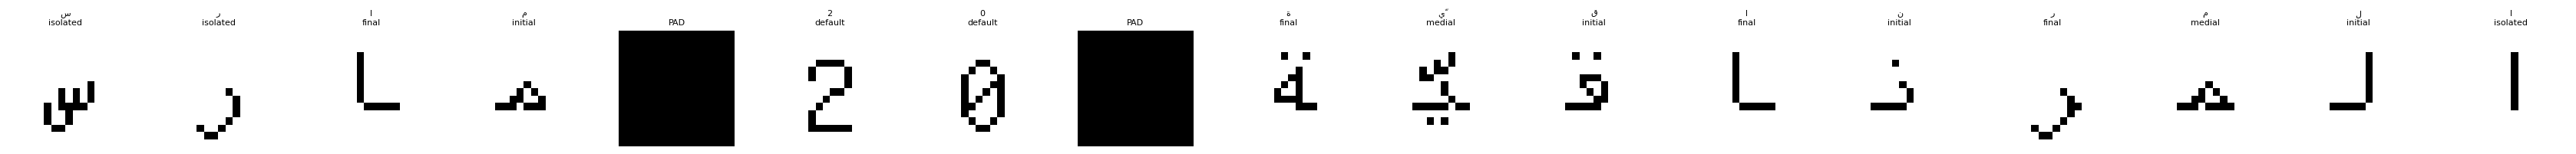

In [4]:
import re
import pickle
import torch
import matplotlib.pyplot as plt
import numpy as np
import unicodedata

# --- Boolean Switch ---
SHOW_HARAKAT = True  # Set to True to show diacritics, False to strip them away

# --- Character Groups ---
arabic_chars   = "ءاأإآابتثجحخدذرزسشصضطظعغفقكلمنهويىئؤة"
arabic_numbers = "٠١٢٣٤٥٦٧٨٩"
english_numbers= "0123456789"
punctuation    = "!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~،؛؟"
symbols        = "$€£¥¢©®±×÷"

# Harakāt set (include sukūn)
harakat_set = set("ًٌٍَُِّْ")

def preprocess_text(text):
    """
    Pre-process the text so that any contiguous sequence of English digits
    is reversed. This ensures that after the overall reversal for RTL display,
    the English numbers appear in their original order.
    """
    def reverse_digits(match):
        return match.group(0)[::-1]
    return re.sub(r'\d+', reverse_digits, text)

def load_unifont_arabic(pickle_path="./unifont_arabic_ext_2.pickle"):
    with open(pickle_path, "rb") as f:
        data = pickle.load(f)
    glyph_entries = data['with_harakat']['glyph_entries']
    letter2index = data['with_harakat']['letter2index']
    total = len(glyph_entries)
    glyph_list = [None] * total
    for entry in glyph_entries:
        idx = entry['idx'][0]
        glyph_list[idx] = torch.from_numpy(entry['mat'].astype(np.float32))
    con_symbols = torch.stack(glyph_list)
    return con_symbols, letter2index

def shape_arabic_text(text, letter2index):
    # Pre-process text so that English digit sequences are reversed.
    text = preprocess_text(text)
    # Normalize the entire text to NFC so that composed characters remain intact.
    text = unicodedata.normalize("NFC", text)
    
    non_joining = set("اأإآدذرزو")
    tokens = []
    i = 0
    n = len(text)
    while i < n:
        char = text[i]
        if char in arabic_chars:
            diacritic = "base"
            if i + 1 < n and text[i+1] in harakat_set:
                diacritic = unicodedata.normalize("NFC", text[i+1])
                i += 2
            else:
                i += 1
            tokens.append((char, diacritic))
        elif text[i] in harakat_set:
            i += 1
        else:
            tokens.append((text[i], None))
            i += 1

    # If the switch is off, strip away diacritics by setting them to "base".
    if not SHOW_HARAKAT:
        tokens = [(char, "base") if char in arabic_chars else (char, d) for char, d in tokens]
    
    indices = []
    labels = []
    num_tokens = len(tokens)
    for i, token in enumerate(tokens):
        char, d = token
        if char in arabic_chars:
            prev_join = (i > 0 and tokens[i-1][0] in arabic_chars and tokens[i-1][0] not in non_joining)
            next_join = (i < num_tokens - 1 and tokens[i+1][0] in arabic_chars)
            curr_joinable = (char not in non_joining)
            if not curr_joinable:
                form = "final" if prev_join else "isolated"
            else:
                if prev_join and next_join:
                    form = "medial"
                elif prev_join and not next_join:
                    form = "final"
                elif not prev_join and next_join:
                    form = "initial"
                else:
                    form = "isolated"
            try:
                idx = letter2index[char][form][d]
            except KeyError:
                idx = letter2index[char]["isolated"]["base"]
            indices.append(idx)
            # Label: if SHOW_HARAKAT is False, diacritic is not shown.
            label = char + (("" if not SHOW_HARAKAT else d) if d != "base" else "") + "\n" + form
            labels.append(label)
        else:
            if char in letter2index:
                if isinstance(letter2index[char], dict):
                    idx = letter2index[char]["default"]
                else:
                    idx = letter2index[char]
                form = "default"
            else:
                idx = letter2index["PAD"]
                form = "PAD"
            indices.append(idx)
            labels.append(char + "\n" + form)
    
    return list(reversed(indices)), list(reversed(labels))

def get_content_glyphs(text, con_symbols, letter2index):
    indices, labels = shape_arabic_text(text, letter2index)
    content = con_symbols[indices]
    content = 1.0 - content
    return content, labels

def plot_glyphs(glyphs, text, labels):
    num_chars = glyphs.shape[0]
    fig, axes = plt.subplots(1, num_chars, figsize=(num_chars * 2, 2))
    if num_chars == 1:
        axes = [axes]
    rev_text = text[::-1]  # Note: reversal is applied after pre-processing.
    for i, ax in enumerate(axes):
        ax.imshow(glyphs[i].numpy(), cmap='gray')
        ax.set_title(labels[i], fontsize=8)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# --- Example Usage ---
pickle_path = "./unifont_arabic.pickle"
con_symbols, letter2index = load_unifont_arabic(pickle_path)
example_text = "المرناقيّة 20 مارس"
glyphs, labels = get_content_glyphs(example_text, con_symbols, letter2index)
plot_glyphs(glyphs, example_text, labels)


Word: الشرايع
Detected Forms: ['final', 'initial', 'isolated', 'final', 'medial', 'initial', 'isolated']


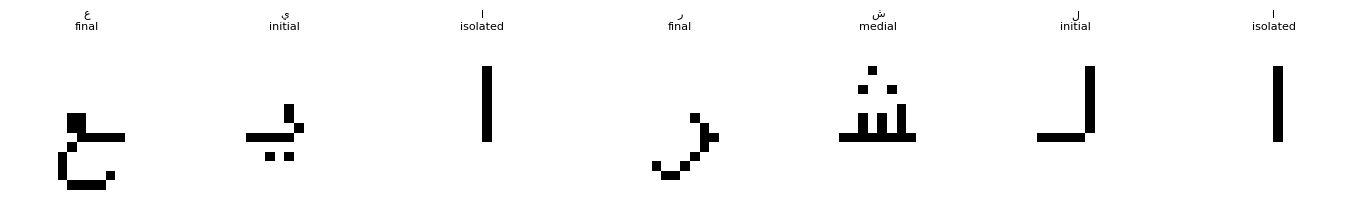

Word: اللواتة
Detected Forms: ['final', 'initial', 'isolated', 'final', 'medial', 'initial', 'isolated']


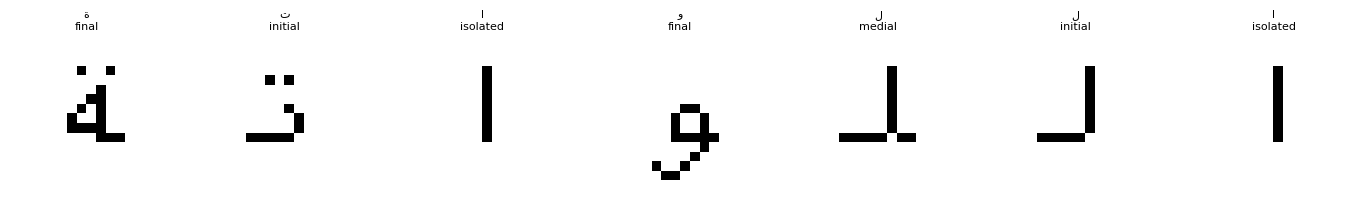

Word: الدخّانية
Detected Forms: ['final', 'medial', 'initial', 'final', 'initial', 'final', 'initial', 'isolated']


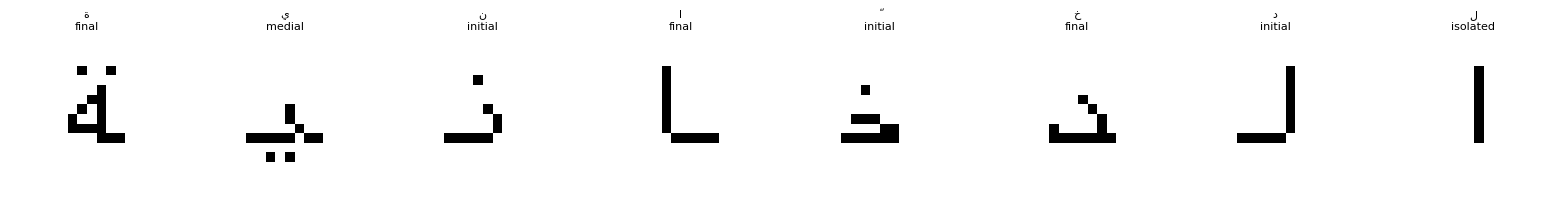

Word: الناضور
Detected Forms: ['isolated', 'final', 'initial', 'final', 'medial', 'initial', 'isolated']


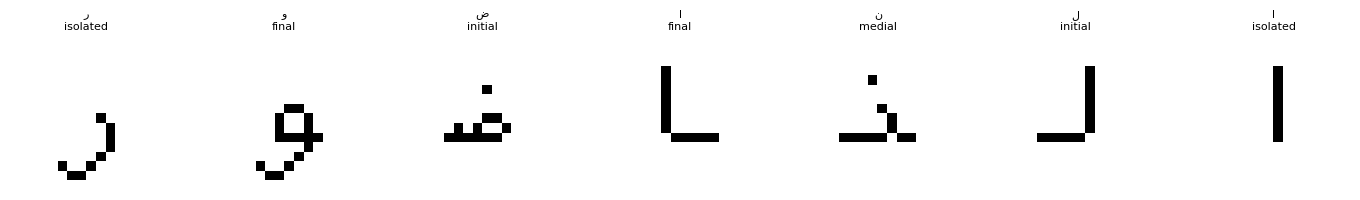

Word: الهيشرّية
Detected Forms: ['final', 'initial', 'final', 'medial', 'medial', 'medial', 'initial', 'isolated']


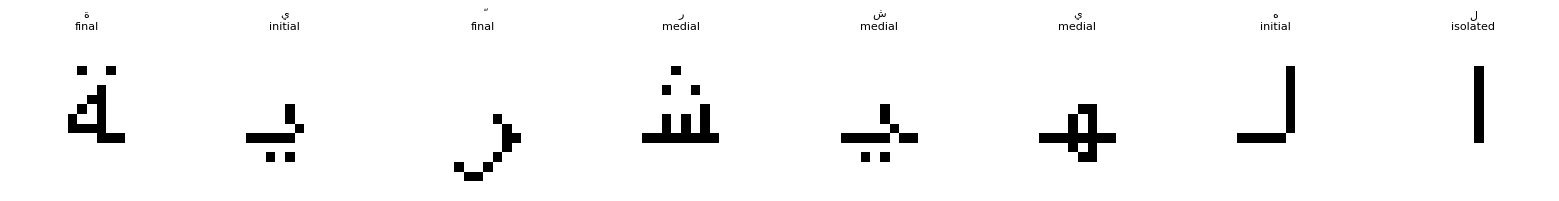

Word: حي التّحرير
Detected Forms: ['final', 'initial', 'final', 'medial', 'medial', 'initial', 'isolated', 'PAD', 'final', 'initial']


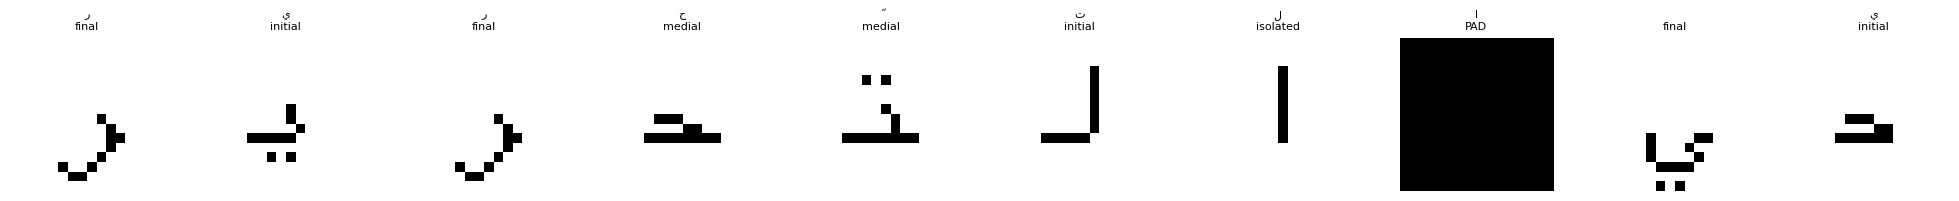

Word: مارث
Detected Forms: ['isolated', 'isolated', 'final', 'initial']


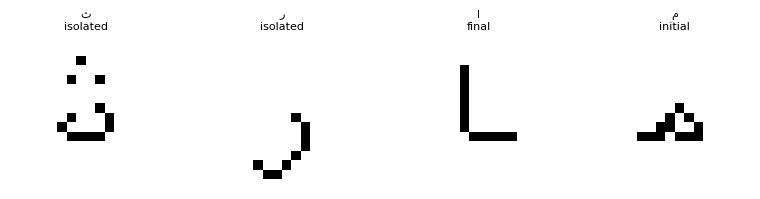

Word: نكريف
Detected Forms: ['final', 'initial', 'final', 'medial', 'initial']


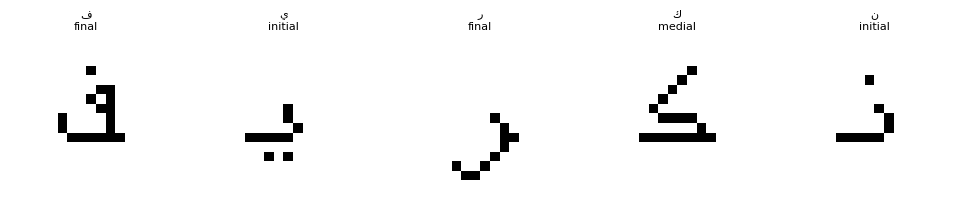

Word: مثلين
Detected Forms: ['final', 'medial', 'medial', 'medial', 'initial']


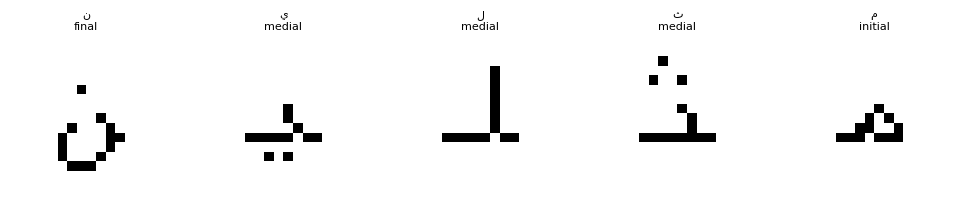

Word: الدخّانية
Detected Forms: ['final', 'medial', 'initial', 'final', 'initial', 'final', 'initial', 'isolated']


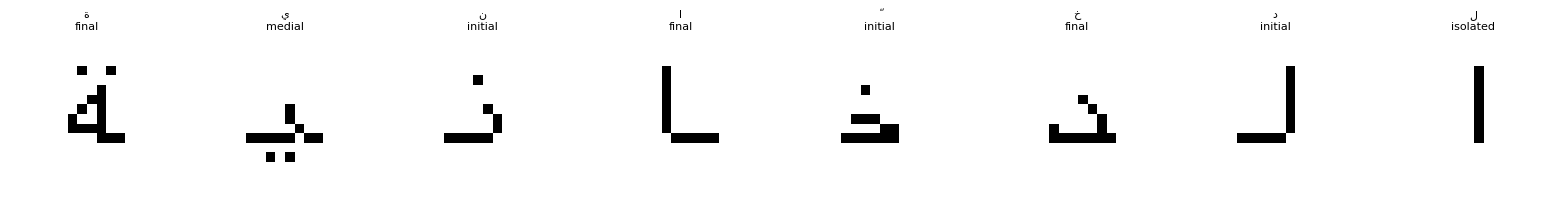

Word: بوفيشة
Detected Forms: ['final', 'medial', 'medial', 'initial', 'final', 'initial']


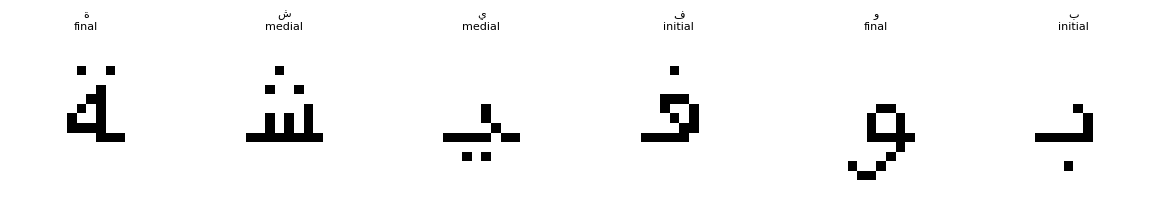

Word: حي الصلاح
Detected Forms: ['isolated', 'final', 'medial', 'medial', 'initial', 'isolated', 'PAD', 'final', 'initial']


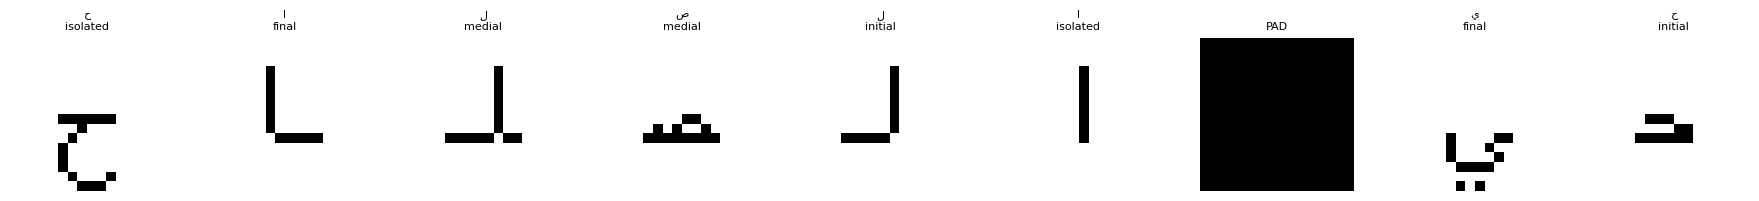

Word: سيدي عثمان
Detected Forms: ['isolated', 'final', 'medial', 'medial', 'initial', 'PAD', 'isolated', 'final', 'medial', 'initial']


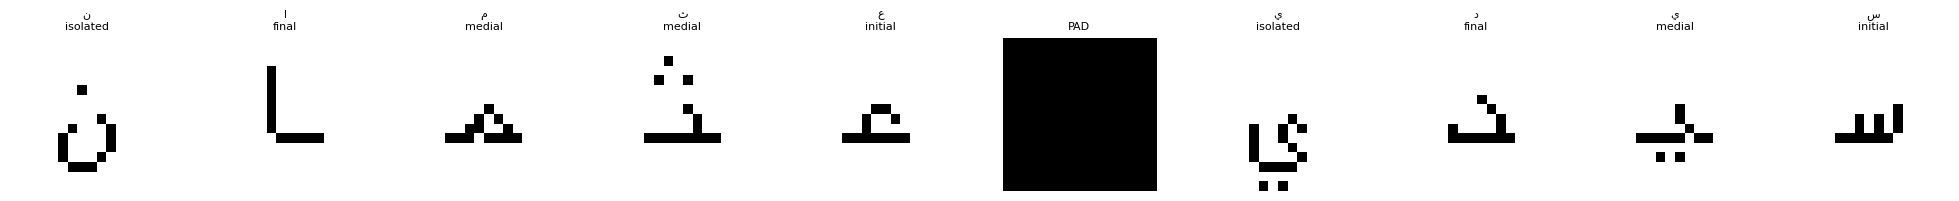

Word: الذويبات
Detected Forms: ['isolated', 'final', 'medial', 'initial', 'isolated', 'final', 'initial', 'isolated']


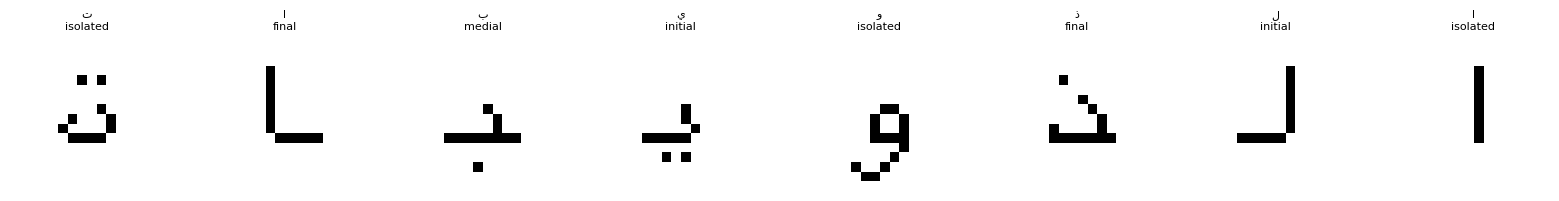

Word: أكّودة
Detected Forms: ['isolated', 'isolated', 'final', 'initial', 'isolated']


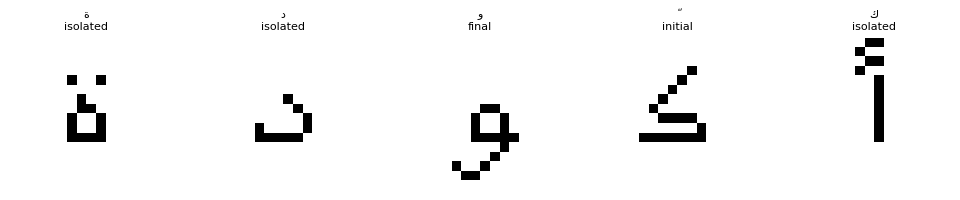

Word: عين الدّفلة
Detected Forms: ['final', 'medial', 'initial', 'final', 'initial', 'isolated', 'PAD', 'final', 'medial', 'initial']


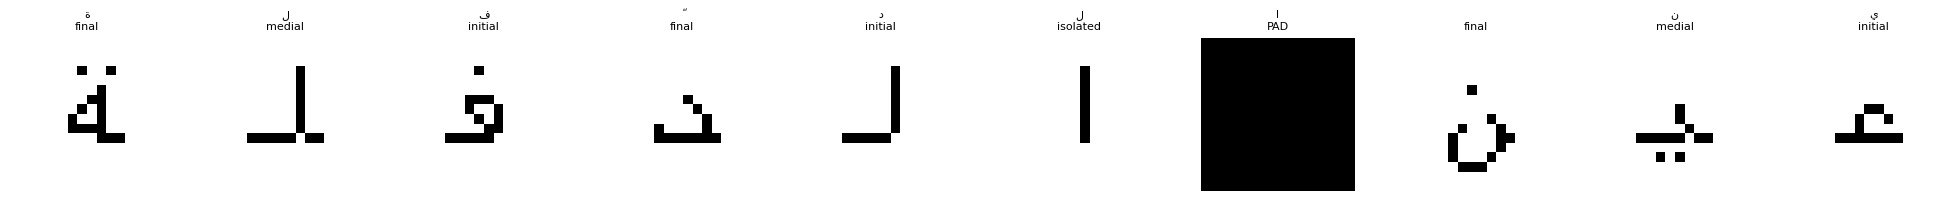

Word: بوعثمان
Detected Forms: ['isolated', 'final', 'medial', 'medial', 'initial', 'final', 'initial']


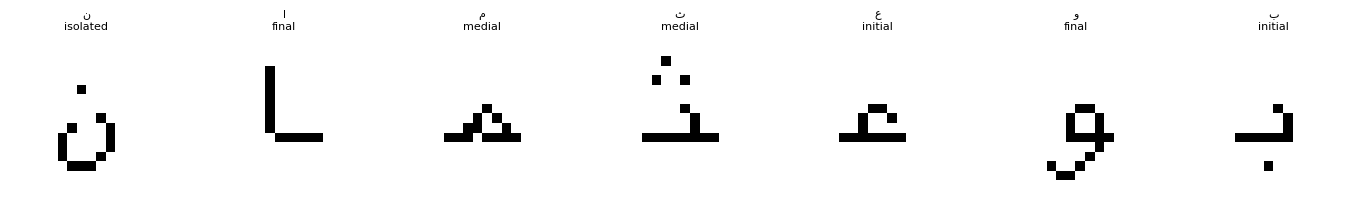

Word: منزل تميم
Detected Forms: ['final', 'medial', 'medial', 'initial', 'PAD', 'isolated', 'final', 'medial', 'initial']


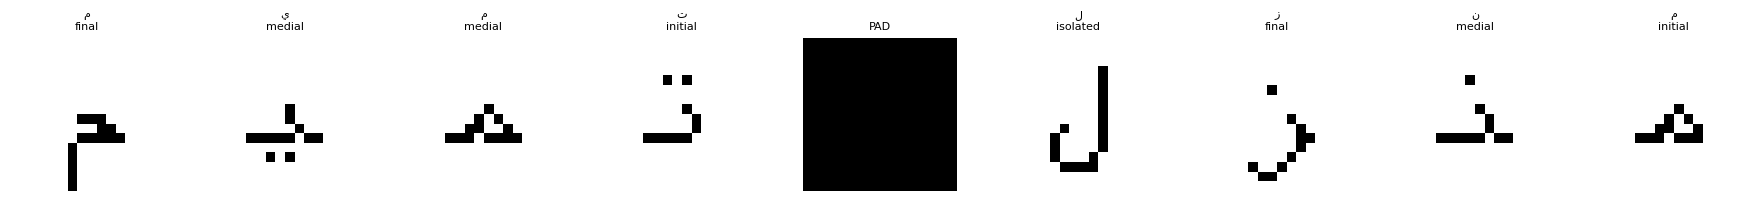

Word: عين تبرنق
Detected Forms: ['final', 'initial', 'final', 'medial', 'initial', 'PAD', 'final', 'medial', 'initial']


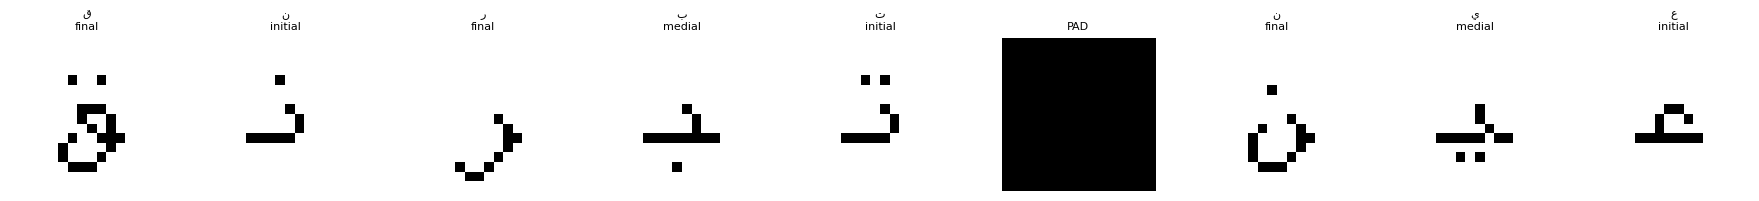

Word: قريبيص
Detected Forms: ['final', 'medial', 'medial', 'initial', 'final', 'initial']


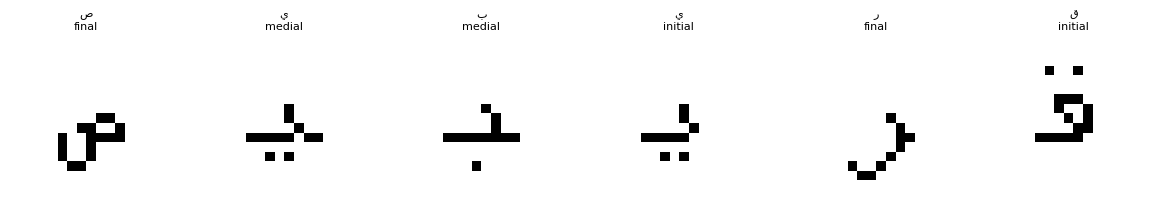

In [6]:
import os
import re
import pickle
import torch
from torch.utils.data import Dataset
import numpy as np
import unicodedata
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# --- Boolean Switch ---
SHOW_HARAKAT = False  # Set to True to show diacritics; False to strip them away

# --- Character Groups ---
arabic_chars   = "ءاأإآابتثجحخدذرزسشصضطظعغفقكلمنهويىئؤة"
arabic_numbers = "٠١٢٣٤٥٦٧٨٩"
english_numbers= "0123456789"
punctuation    = "!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~،؛؟"
symbols        = "$€£¥¢©®±×÷"

# Define the order of characters (if needed for content mapping).
letters = arabic_chars + arabic_numbers + english_numbers + punctuation + symbols

# --- Harakāt set (include sukūn) ---
harakat_set = set("ًٌٍَُِّْ")

# --- Preprocessing Function ---
def preprocess_text(text):
    """
    Pre-process the text so that any contiguous sequence of English digits
    is reversed. This ensures that after the overall reversal for RTL display,
    the English numbers appear in their original order.
    For example, "20" becomes "02" here, and after reversal becomes "20".
    """
    def reverse_digits(match):
        return match.group(0)[::-1]
    return re.sub(r'\d+', reverse_digits, text)

def effective_length(text):
    """
    Computes the effective length of a text, ignoring any harakāt (diacritics).
    The text is first normalized to NFD so that diacritics are decomposed.
    Then, any character that is a Unicode combining mark is filtered out.
    """
    # Normalize text to NFD to separate base characters and diacritics
    decomposed = unicodedata.normalize("NFD", text)
    # Count only characters that are not combining marks
    return len([ch for ch in decomposed if not unicodedata.combining(ch)])

# --- Function to Load Unifont Glyphs and Mapping ---
def load_unifont_arabic(pickle_path="unifont_arabic.pickle"):
    """
    Loads the pre-generated pickle file containing a list of glyph entries and the
    letter-to-index mapping. Each glyph is a 16×16 binary NumPy array converted to a torch tensor.
    Returns:
      - con_symbols: A tensor of shape (total_glyphs, 16, 16)
      - letter2index: A dictionary mapping each character (for Arabic letters, a dict of forms)
                      to its corresponding index in con_symbols.
    """
    with open(pickle_path, "rb") as f:
        data = pickle.load(f)
    glyph_entries = data['with_harakat']['glyph_entries']
    letter2index = data['with_harakat']['letter2index']
    total = len(glyph_entries)
    glyph_list = [None] * total
    for entry in glyph_entries:
        idx = entry['idx'][0]
        glyph_list[idx] = torch.from_numpy(entry['mat'].astype(np.float32))
    con_symbols = torch.stack(glyph_list)
    return con_symbols, letter2index

# --- Joining Heuristic Functions ---
def shape_arabic_text(text, letter2index):
    """
    Processes the input text as follows:
      1. Pre-processes English digit sequences,
      2. Normalizes the entire text to NFC (to keep composed characters intact),
      3. Tokenizes the text into (char, diacritic) pairs for Arabic letters,
         keeping non-Arabic characters unchanged.
      4. If SHOW_HARAKAT is False, forces each Arabic letter's diacritic to "base".
      5. Determines the appropriate contextual form (isolated, initial, medial, final)
         for each Arabic letter based on its neighbors.
      6. Returns two lists: one of glyph indices (for lookup) and one of detected forms.
         Finally, both lists are reversed to simulate right-to-left display.
    """
    text = preprocess_text(text)
    text = unicodedata.normalize("NFC", text)
    
    non_joining = set("اأإآدذرزو")
    tokens = []
    i = 0
    n = len(text)
    # Tokenization: group each Arabic letter with its following diacritic (if any)
    while i < n:
        char = text[i]
        if char in arabic_chars:
            diacritic = "base"
            if i + 1 < n and text[i+1] in set("ًٌٍَُِّْ"):
                diacritic = unicodedata.normalize("NFC", text[i+1])
                i += 2
            else:
                i += 1
            tokens.append((char, diacritic))
        elif text[i] in set("ًٌٍَُِّْ"):
            i += 1
        else:
            tokens.append((text[i], None))
            i += 1

    # If harakāt are not to be shown, force all Arabic letters to use "base".
    if not SHOW_HARAKAT:
        tokens = [(char, "base") if char in arabic_chars else (char, d) for char, d in tokens]

    indices = []
    forms_detected = []
    num_tokens = len(tokens)
    for i, token in enumerate(tokens):
        char, d = token
        if char in arabic_chars:
            prev_join = (i > 0 and tokens[i-1][0] in arabic_chars and tokens[i-1][0] not in non_joining)
            next_join = (i < num_tokens - 1 and tokens[i+1][0] in arabic_chars)
            curr_joinable = (char not in non_joining)
            if not curr_joinable:
                form = "final" if prev_join else "isolated"
            else:
                if prev_join and next_join:
                    form = "medial"
                elif prev_join and not next_join:
                    form = "final"
                elif not prev_join and next_join:
                    form = "initial"
                else:
                    form = "isolated"
            try:
                idx = letter2index[char][form]["base"]
            except KeyError:
                idx = letter2index[char]["isolated"]["base"]
            indices.append(idx)
            forms_detected.append(form)
        else:
            # For non-Arabic characters, use the "default" mapping.
            if char in letter2index:
                if isinstance(letter2index[char], dict):
                    idx = letter2index[char]["default"]
                else:
                    idx = letter2index[char]
                form = "default"
            else:
                idx = letter2index["PAD"]
                form = "PAD"
            indices.append(idx)
            forms_detected.append(form)
    
    return list(reversed(indices)), list(reversed(forms_detected))

def get_content_glyphs(text, con_symbols, letter2index):
    indices, forms = shape_arabic_text(text, letter2index)
    content = con_symbols[indices]
    content = 1.0 - content
    return content, forms

# --- ContentData Dataset Class ---
class ContentData(Dataset):
    def __init__(self, text_path, pickle_path="unifont_arabic.pickle", max_len=10):
        """
        Loads handwritten Arabic word transcriptions from a text file (formatted as in the IAM dataset)
        and prepares each word's glyph representations using our Unifont mapping and context-aware joining heuristic.
        
        Note: Each line is expected to be formatted as:
            "writerID,image_filename transcription..."
        and everything after the first field is taken as the transcription.
        The maximum length (max_len) is measured by counting only characters that are not harakāt.
        """
        with open(text_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        self.words = []
        for line in lines:
            parts = line.strip().split(' ', 1)  # Split once so that transcription may contain spaces.
            if len(parts) < 2:
                continue
            transcription = parts[1]
            if effective_length(transcription) > max_len:
                continue
            self.words.append(transcription)
        self.max_len = max_len
        self.letters = letters
        self.con_symbols, self.letter2index = load_unifont_arabic(pickle_path)
        
    def __len__(self):
        return len(self.words)
    
    def __getitem__(self, idx):
        word = self.words[idx]
        content, forms = get_content_glyphs(word, self.con_symbols, self.letter2index)
        return {"word": word, "content": content, "forms": forms}

# --- Plotting Function ---
def plot_glyphs(glyphs, word, labels):
    """
    Plots the glyph images corresponding to the given word.
    Each subplot displays the character (in right-to-left order) along with its detected contextual form.
    """
    num_chars = glyphs.shape[0]
    fig, axes = plt.subplots(1, num_chars, figsize=(num_chars * 2, 2))
    rev_word = word[::-1]  # Reverse the word for RTL display.
    for i, ax in enumerate(axes):
        ax.imshow(glyphs[i].numpy(), cmap='gray')
        ax.set_title(f"{rev_word[i]}\n{labels[i]}", fontsize=8)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# --- Example Usage ---
if __name__ == "__main__":
    # Path to the IAM train text file (each line: "writerID,image_filename transcription...")
    text_file = "/Users/hamza/Research/One-DM/Training Datasets/ifnenit_words.txt"  # Adjust this path as needed.
    
    
    # Create the content dataset.
    dataset = ContentData(text_file, pickle_path="unifont_arabic.pickle")
    
    # For demonstration, pick a few words from the dataset.
    for i in range(min(20, len(dataset))):
        sample = dataset[i]
        print("Word:", sample["word"])
        print("Detected Forms:", sample["forms"])
        plot_glyphs(sample["content"], sample["word"], sample["forms"])
